# Final Project - example solution

This notebook demonstrates the integration of TabPFN for two tasks:
1.  **Regression**: Predicting the target variable `y`.
2.  **Markov Blanket (MB) Discovery**: Identifying the optimal feature set using TabPFN embeddings.

In [1]:
!git clone https://github.com/Shu-Wan/CSE472-blanket-challenge.git

Cloning into 'CSE472-blanket-challenge'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 204 (delta 88), reused 154 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 2.95 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [3]:
!pip install ./CSE472-blanket-challenge/

Processing ./CSE472-blanket-challenge
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install "tabpfn-extensions[interpretability]"

In [72]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset
from pathlib import Path
import torch

from blanket.plots import plot_graph
from blanket.metrics import rmse, jaccard_score

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabpfn_extensions.embedding import TabPFNEmbedding

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

load_dotenv()
logging.basicConfig(level=logging.ERROR)

# Load data

In [6]:
develop = load_dataset("CSE472-blanket-challenge/final-dataset", 'develop', split='train')
submit = load_dataset("CSE472-blanket-challenge/final-dataset", 'submit', split='train')

README.md:   0%|          | 0.00/805 [00:00<?, ?B/s]

develop.jsonl:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182 [00:00<?, ? examples/s]

submit.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/46 [00:00<?, ? examples/s]

In [ ]:
print(len(develop), len(submit))

182 46


[🤗 Dataset](CSE472-blanket-challenge/final-dataset)

Develop: 182 datasets

- X_train, y_train, X_test, y_test, metadata

Subumit: 46 datasets

- X_train, y_train, X_test

Develop and Submit use the same script for data generation.

For generation details, refer to <https://huggingface.co/datasets/CSE472-blanket-challenge/final-dataset>

You task:

1. Train a model using `develop` to predict `y` and `markov_blanket`
2. Test your model on `submit`


In [7]:
# Select Test Case
example_data = develop[89]
X_train = np.asarray(example_data['X_train'])
y_train = np.asarray(example_data['y_train'])
X_test = np.asarray(example_data['X_test'])
y_test = np.asarray(example_data['y_test'])

print(f"Example data id: {example_data['data_id']}")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Env: {example_data['environment']}")
print(f"SCM: {example_data['scm']}")

Example data id: data_96c77df4
Train shape: (400, 9)
Test shape: (100, 9)
Env: {'method': 'covariate', 'projection': 'pca', 'shift_mean': 0.8, 'shift_std': 0.2, 'train_fraction': 0.8}
SCM: {'coeff_range': 1.0, 'functional': 'linear', 'noise_std': 0.5, 'seed': 51}


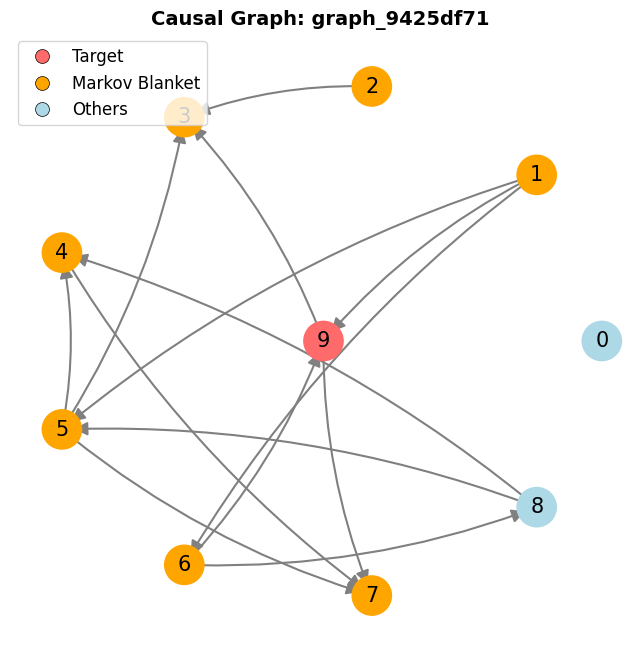

In [8]:
# Visualize Causal Graph
plot_graph(example_data['adjacency_matrix'], title=f"Causal Graph: {example_data['graph_id']}", figsize=(8, 8))
plt.show()

# TabPFN models

In [9]:
from tabpfn.model_loading import ModelSource
regressor_models = ModelSource.get_regressor_v2_5()

print("Available TabPFN Regressor Models:\n", )
for model_name in regressor_models.filenames:
    print(f"  {model_name}")

Available TabPFN Regressor Models:

  tabpfn-v2.5-regressor-v2.5_default.ckpt
  tabpfn-v2.5-regressor-v2.5_low-skew.ckpt
  tabpfn-v2.5-regressor-v2.5_quantiles.ckpt
  tabpfn-v2.5-regressor-v2.5_real-variant.ckpt
  tabpfn-v2.5-regressor-v2.5_real.ckpt
  tabpfn-v2.5-regressor-v2.5_small-samples.ckpt
  tabpfn-v2.5-regressor-v2.5_variant.ckpt


TabPFN load `tabpfn-v2.5-regressor-v2.5_default.ckpt` by default

the `real` variant are fine-tuned on real world dataset

For details, see TabPFN's [technical report](https://storage.googleapis.com/prior-labs-tabpfn-public/reports/TabPFN_2_5_tech_report.pdf)

In [62]:
from tabpfn.model_loading import ModelSource
classifier_models = ModelSource.get_classifier_v2_5()

print("Available TabPFN Classifier Models:\n", )
for model_name in classifier_models.filenames:
    print(f"  {model_name}")

Available TabPFN Regressor Models:

  tabpfn-v2.5-classifier-v2.5_default.ckpt
  tabpfn-v2.5-classifier-v2.5_default-2.ckpt
  tabpfn-v2.5-classifier-v2.5_large-features-L.ckpt
  tabpfn-v2.5-classifier-v2.5_large-features-XL.ckpt
  tabpfn-v2.5-classifier-v2.5_large-samples.ckpt
  tabpfn-v2.5-classifier-v2.5_real-large-features.ckpt
  tabpfn-v2.5-classifier-v2.5_real-large-samples-and-features.ckpt
  tabpfn-v2.5-classifier-v2.5_real.ckpt
  tabpfn-v2.5-classifier-v2.5_variant.ckpt


In [64]:
import os
from huggingface_hub import hf_hub_download

TABPFN_MODEL_CACHE_DIR = None #Path(os.getenv("TABPFN_MODEL_CACHE_DIR", None))

model_path = hf_hub_download(repo_id=regressor_models.repo_id, filename="tabpfn-v2.5-regressor-v2.5_real.ckpt", local_dir=TABPFN_MODEL_CACHE_DIR)

In [65]:
model_path_cls = hf_hub_download(repo_id=regressor_models.repo_id, filename="tabpfn-v2.5-classifier-v2.5_real.ckpt", local_dir=TABPFN_MODEL_CACHE_DIR)

In [119]:
# tabpfn is a subclass of sklearn estimators, so it has the same API
# toy example
regressor_config = {
        "ignore_pretraining_limits": True,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "n_estimators": 30,
        "random_state":42,
        "inference_precision": "auto"
    }

regressor = TabPFNRegressor(model_path = model_path, **regressor_config)

regressor.fit(X_train, y_train)

preds = regressor.predict(X_test)

print("RMSE:", rmse(y_test, preds))

RMSE: 0.3870381868180063


In [120]:
from sklearn.inspection import permutation_importance

# Compute SHAP values
r = permutation_importance(regressor, X_train, y_train,
    n_repeats=5,
    random_state=0,n_jobs=5)


In [16]:
r

{'importances_mean': array([3.82503697e-04, 5.31715328e-02, 1.87440767e-03, 2.71645077e-04,
        6.98318566e-02, 6.59420343e-02, 2.89722626e-01, 8.94772210e-01,
        1.38887746e-03]),
 'importances_std': array([8.92423020e-05, 9.99046290e-03, 1.04122834e-03, 1.59684533e-04,
        7.70833932e-03, 1.05513519e-02, 2.76874056e-02, 6.17075527e-02,
        4.38896987e-04]),
 'importances': array([[ 2.96725950e-04,  4.69445784e-04,  3.80106339e-04,
          2.71545822e-04,  4.94694591e-04],
        [ 5.07270971e-02,  4.11867436e-02,  6.73718019e-02,
          4.46905917e-02,  6.18814295e-02],
        [ 1.84709798e-03,  3.59275960e-03,  1.02056835e-03,
          6.22797448e-04,  2.28881498e-03],
        [ 3.37970390e-04,  2.38145774e-04,  4.53066634e-04,
          3.46331232e-04, -1.72886461e-05],
        [ 7.88618132e-02,  6.70010508e-02,  6.45532661e-02,
          7.88386685e-02,  5.99044844e-02],
        [ 7.86025361e-02,  7.11873073e-02,  5.32661416e-02,
          7.31886312e-02, 

In [18]:
example_data['feature_mask']

[0, 1, 1, 1, 1, 1, 1, 1, 0]

In [21]:
import seaborn as sns

In [26]:
np.cov(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)[:-1,-1]

array([-0.02651205, -0.29883155, -0.00298944, -0.04982617,  0.08657704,
        0.29794745,  0.48758048, -0.928915  , -0.23013276])

<Axes: >

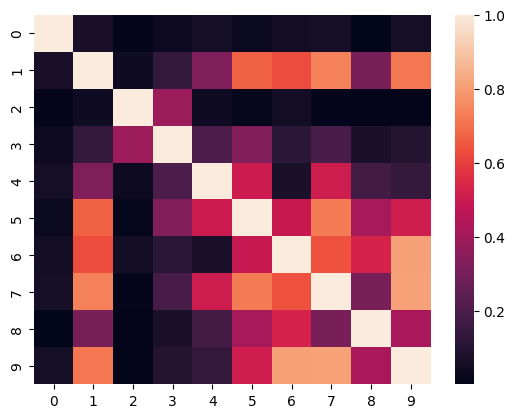

In [30]:
sns.heatmap(abs(np.corrcoef(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)))

In [58]:
def get_features(sample):
    X_train = np.asarray(sample['X_train'])
    y_train = np.asarray(sample['y_train'])
    #X_test = np.asarray(sample['X_test'])
    #y_test = np.asarray(sample['y_test'])
    regressor_config = {
        "ignore_pretraining_limits": True,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "n_estimators": 8,
        "random_state":42,
        "inference_precision": "auto"
    }

    regressor = TabPFNRegressor(model_path = model_path, **regressor_config)

    regressor.fit(X_train, y_train)

    r = permutation_importance(
        regressor,
        X_train,
        y_train,
        n_repeats=3,
        random_state=0,n_jobs=5
    )
    cov = np.cov(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)[:-1,-1]
    corr = np.corrcoef(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)[:-1,-1]
    return {
        'importance_mean': r.importances_mean,
        'importance_std': r.importances_std,
        'covariance': cov,
        'correlation': corr,
        'feature_mask': sample['feature_mask'],
    }


In [49]:
import pandas as pd
df = pd.DataFrame()

In [80]:
from tqdm import tqdm
df = pd.DataFrame()
for i in tqdm(range(len(develop))):
    data = develop[i]
    features = get_features(data)
    new_rows = pd.DataFrame(features)
    df = pd.concat([df, new_rows], ignore_index=True)

100%|██████████| 182/182 [28:03<00:00,  9.25s/it]


In [81]:
cls_config = {
    "ignore_pretraining_limits": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "n_estimators": 60,
    "random_state":42,
    "inference_precision": "auto"
}

cls = TabPFNClassifier(model_path = model_path_cls, **regressor_config)

In [82]:
df

,importance_mean,importance_std,covariance,correlation,feature_mask
0,0.632935,0.030129,0.194473,0.432340,1
1,0.015272,0.002393,-0.007023,-0.028583,1
2,0.192268,0.029852,-0.004113,-0.015818,1
3,0.000889,0.000289,-0.015105,-0.036825,0
4,0.099347,0.003329,0.016774,0.066446,1
...,...,...,...,...,...
2583,0.014816,0.003510,0.041287,0.084845,0
2584,0.374592,0.026253,-0.196430,-0.613153,1
2585,0.127690,0.022574,0.015942,0.051094,1
2586,0.005878,0.001304,-0.015250,-0.048557,0


In [83]:
df.to_csv('encoded_features.csv')

In [102]:
cls.fit(df.loc[:, ['importance_mean', 'importance_std', 'covariance', 'correlation']], df.loc[:, 'feature_mask'])

TabPFNClassifier(device='cuda', ignore_pretraining_limits=True,
                 model_path='/root/.cache/huggingface/hub/models--Prior-Labs--tabpfn_2_5/snapshots/bb578e06ac804b6993b848d9b266ef4285124e66/tabpfn-v2.5-classifier-v2.5_real.ckpt',
                 n_estimators=30, random_state=42)

In [106]:
def predict_submission(sample):
    X_train = np.asarray(sample['X_train'])
    y_train = np.asarray(sample['y_train'])
    X_test = np.asarray(sample['X_test'])

    regressor_config = {
        "ignore_pretraining_limits": True,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "n_estimators": 24,
        "random_state":42,
        "inference_precision": "auto"
    }

    regressor = TabPFNRegressor(model_path = model_path, **regressor_config)

    regressor.fit(X_train, y_train)

    pred_y = regressor.predict(X_test)

    r = permutation_importance(
        regressor,
        X_train,
        y_train,
        n_repeats=3,
        random_state=0,n_jobs=5
    )
    cov = np.cov(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)[:-1,-1]
    corr = np.corrcoef(np.concatenate([X_train, y_train[:, np.newaxis]], axis=1), rowvar=False)[:-1,-1]
    features = {
        'importance_mean': r.importances_mean,
        'importance_std': r.importances_std,
        'covariance': cov,
        'correlation': corr,
    }
    df = pd.DataFrame(features)

    pred_mb = cls.predict(df)

    return pred_y, pred_mb

In [111]:
submission_df = pd.DataFrame()
for i in tqdm(range(len(submit))):
    pred_y, pred_mb = predict_submission(submit[i])
    result = pd.DataFrame({
        'data_id': submit[i]['data_id'],
        'y_pred': [pred_y.tolist()],
        'markov_blanket_pred': [pred_mb.tolist()]
    })
    submission_df = pd.concat([submission_df, result], ignore_index=True)

100%|██████████| 46/46 [22:46<00:00, 29.70s/it]


In [117]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

results = []

for train_index, test_index in kf.split(df):
    cls_config = {
        "ignore_pretraining_limits": True,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "n_estimators": 60,
        "random_state":42,
        "inference_precision": "auto"
    }

    cls_val = TabPFNClassifier(model_path = model_path_cls, **regressor_config)
    cls_val.fit(df.loc[train_index, ['importance_mean', 'importance_std', 'covariance', 'correlation']], df.loc[train_index, 'feature_mask'])
    pred_mb = cls_val.predict(df.loc[test_index, ['importance_mean', 'importance_std', 'covariance', 'correlation']])
    print(jaccard_score(df.loc[test_index, 'feature_mask'], pred_mb))
    results.append(jaccard_score(df.loc[test_index, 'feature_mask'], pred_mb))

0.5622119815668203
0.5758754863813229
0.5955882352941176
0.6208333333333333
0.45993031358885017


In [118]:
np.array(results).mean()


np.float64(0.5628878700328889)

In [112]:
submission_df

,data_id,y_pred,markov_blanket_pred
0,data_199180bb,"[-0.9095904231071472, -0.07463124394416809, 0....","[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,data_36d2b833,"[0.7128349542617798, 1.0130257606506348, 0.811...","[1, 1, 1, 0, 0, 0, 1, 1, 1]"
2,data_e84cde01,"[-0.6406248807907104, -0.22356030344963074, -1...","[1, 1, 0, 0, 0, 1, 0, 0, 0]"
3,data_d4df06d1,"[0.10810604691505432, -0.03417778015136719, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,data_645b0390,"[1.1282484531402588, 0.6140909194946289, 1.071...","[1, 1, 1, 0, 0, 1, 1, 0, 0]"
5,data_a017dbde,"[0.09558415412902832, -0.038413241505622864, -...","[0, 1, 1, 0, 0, 0, 0, 0, 0]"
6,data_f308f199,"[-0.16699272394180298, -0.04396844655275345, -...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7,data_d3895e55,"[0.6752207279205322, 0.04135867953300476, 1.26...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."
8,data_64fb3c1c,"[0.36148327589035034, -0.5004006624221802, -0....","[1, 0, 0, 0, 1, 0, 0, 0, 0]"
9,data_9bdeddda,"[1.1107561588287354, 1.1771183013916016, 1.103...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [113]:
submission_df.to_csv('submission.csv')